# Système de Prévision des Ventes 

## Introduction

## Objectif

## I- Analyse Exploratoire des Données

## Chargement des Données

In [1]:
import pandas as pd
from geopy.distance import geodesic

import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")


In [2]:
db_orders = pd.read_csv('archive/olist_orders_dataset.csv')
db_products = pd.read_csv('archive/olist_products_dataset.csv')
db_customers = pd.read_csv('archive/olist_customers_dataset.csv')
db_order_items = pd.read_csv('archive/olist_order_items_dataset.csv')
db_sellers = pd.read_csv('archive/olist_sellers_dataset.csv')
db_geolocation = pd.read_csv('archive/olist_geolocation_dataset.csv')



db_orders = db_orders[['order_id', 'customer_id', 'order_purchase_timestamp', 'order_status','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date']]
db_products = db_products[['product_id', 'product_category_name','product_weight_g','product_length_cm','product_height_cm','product_width_cm']]
db_customers = db_customers[['customer_id', 'customer_unique_id', 'customer_zip_code_prefix','customer_city', 'customer_state']]
db_order_items = db_order_items[['order_id', 'product_id', 'seller_id', 'price', 'freight_value']]
db_sellers = db_sellers[['seller_id','seller_zip_code_prefix']]


# Fusionner les colonnes pour créer un seul fichier csv
merged_df = pd.merge(db_orders, db_order_items, on='order_id', how='left')
merged_df = pd.merge(merged_df, db_products, on='product_id', how='left')
merged_df = pd.merge(merged_df, db_customers, on='customer_id', how='left')
merged_df = pd.merge(merged_df, db_sellers, on='seller_id')

## Prétraitement des Données

In [3]:
# Les dimensions du produit
merged_df['volume_cm3'] = merged_df['product_length_cm'] * merged_df['product_height_cm'] * merged_df['product_width_cm']

#Supprimer les lignes les articles indisponible
merged_df = merged_df[merged_df['order_status'] != 'unavailable']

#Supprimer les commandes annuler
merged_df = merged_df[merged_df['order_status'] != 'canceled']

#Supprimer les commandes non livrés
merged_df = merged_df[merged_df['order_status'] != 'created']
#merged_df = merged_df[merged_df['order_status'] != 'invoiced']
#merged_df = merged_df[merged_df['order_status'] != 'shipped']
#merged_df = merged_df[merged_df['order_status'] != 'processing'


#Supprimer les commandes qui contient pas de prix ni de freight value
merged_df = merged_df.dropna(subset=['price','freight_value','product_id'])

#Remplacer les valeurs nulles dans la colonne 'product_category_name' par 'Other'
merged_df['product_category_name'].fillna('Other', inplace=True)


# Enregistrer le nouveau DataFrame fusionné dans un fichier CSV
merged_df.to_csv('Dataset_final.csv', index=False)

## Aperçu des Données

In [4]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
dt = pd.read_csv('Dataset_final.csv')

print(dt.head()) # les premières lignes de notre dataset

                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_purchase_timestamp order_status    order_approved_at  \
0      2017-10-02 10:56:33    delivered  2017-10-02 11:07:15   
1      2018-07-24 20:41:37    delivered  2018-07-26 03:24:27   
2      2018-08-08 08:38:49    delivered  2018-08-08 08:55:23   
3      2017-11-18 19:28:06    delivered  2017-11-18 19:45:59   
4      2018-02-13 21:18:39    delivered  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08

In [6]:
print(dt.info()) # information générales sur le dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112101 entries, 0 to 112100
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       112101 non-null  object 
 1   customer_id                    112101 non-null  object 
 2   order_purchase_timestamp       112101 non-null  object 
 3   order_status                   112101 non-null  object 
 4   order_approved_at              112086 non-null  object 
 5   order_delivered_carrier_date   111380 non-null  object 
 6   order_delivered_customer_date  110189 non-null  object 
 7   product_id                     112101 non-null  object 
 8   seller_id                      112101 non-null  object 
 9   price                          112101 non-null  float64
 10  freight_value                  112101 non-null  float64
 11  product_category_name          112101 non-null  object 
 12  product_weight_g              

In [7]:
print(dt.describe()) # Description des données (moyenne, std, min...)

               price  freight_value  product_weight_g  product_length_cm  \
count  112101.000000  112101.000000     112083.000000      112083.000000   
mean      120.377166      19.992028       2093.615187          30.154493   
std       182.637401      15.797782       3751.385096          16.153039   
min         0.850000       0.000000          0.000000           7.000000   
25%        39.900000      13.080000        300.000000          18.000000   
50%        74.900000      16.270000        700.000000          25.000000   
75%       134.900000      21.150000       1800.000000          38.000000   
max      6735.000000     409.680000      40425.000000         105.000000   

       product_height_cm  product_width_cm  customer_zip_code_prefix  \
count      112083.000000     112083.000000             112101.000000   
mean           16.584451         22.994352              35154.886914   
std            13.435684         11.700765              29871.014203   
min             2.000000   

## II- Prédiction de Délais de Livraison

In [8]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor


import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

## Chargement des Données

In [9]:
#Dataset
data = pd.read_csv ('Dataset_final.csv',sep=',')

## Encodage des Villes

In [10]:
#Encoder la colonne des villes customer_city
label_encoder = LabelEncoder()
data['customer_city_encoded']= label_encoder.fit_transform(data['customer_city'])

## Conversion des Dates en Format Numérique

In [11]:
date_ref = pd.Timestamp('2017-01-01')
for col in ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_customer_date','order_delivered_carrier_date']:
    data[col] = pd.to_datetime(data[col], errors='coerce')
    data[f'{col}_days'] = (data[col] - date_ref).dt.days

## Distance entre Vendeur et Client 

In [12]:
db_geolocation = pd.read_csv('archive/olist_geolocation_dataset.csv')


# calcul des coordonnées moyennes pour chaque code postal
customer_location = db_geolocation.groupby('geolocation_zip_code_prefix').agg({'geolocation_lat':'mean', 'geolocation_lng':'mean'}).rename(columns={'geolocation_lat': 'customer_lat', 'geolocation_lng':'customer_lng'})
sellers_location = db_geolocation.groupby('geolocation_zip_code_prefix').agg({'geolocation_lat':'mean', 'geolocation_lng':'mean'}).rename(columns={'geolocation_lat': 'seller_lat', 'geolocation_lng':'seller_lng'})

data = pd.merge(data, customer_location, left_on='customer_zip_code_prefix', right_index=True)
data = pd.merge(data, sellers_location, left_on='seller_zip_code_prefix', right_index=True)

#calculer la distance entre le client et le vendeur 
def distance(r):
    customer_coord = (r['customer_lat'], r['customer_lng'])
    seller_coord = (r['seller_lat'], r['seller_lng'])
    return geodesic(customer_coord, seller_coord).kilometers

data['distance_km'] = data.apply(distance, axis=1)

# Enregistrer le nouveau DataFrame fusionné dans un fichier CSV
data.to_csv('Dataset_final.csv', index=False)


## Suppression des données aberrantes

In [13]:
# Retirer les commandes non livrés 
data = data[~data['order_delivered_customer_date'].isna()]

# Calculer la durée de livraison pour chaque commande en jours
data['delivery_time'] = (data['order_delivered_customer_date'] - data['order_purchase_timestamp']).dt.days

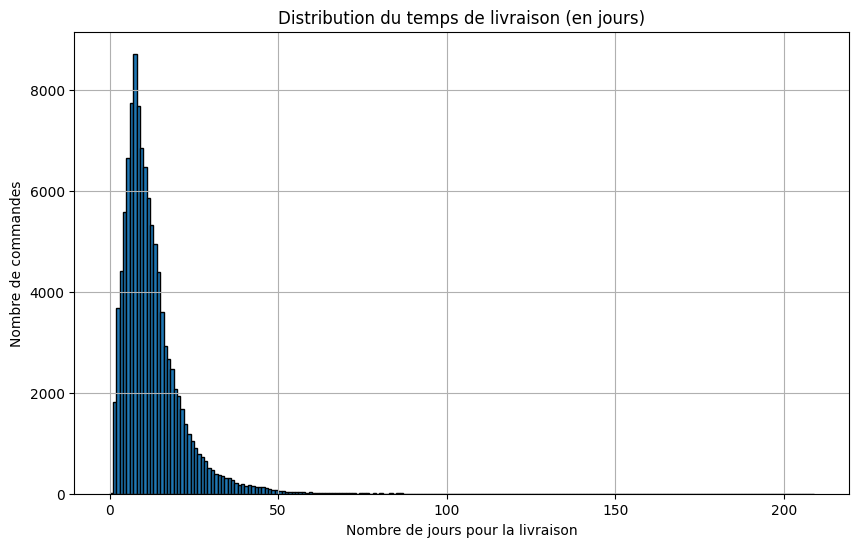

In [14]:
plt.figure(figsize=(10, 6))
plt.hist(data['delivery_time'], bins=range(0, data['delivery_time'].max() + 1), edgecolor='black')
plt.title('Distribution du temps de livraison (en jours)')
plt.xlabel('Nombre de jours pour la livraison')
plt.ylabel('Nombre de commandes')
plt.grid(True)
plt.show()

In [15]:
# Supprimer les données aberrantes
data = data[data['delivery_time'] <= 30]

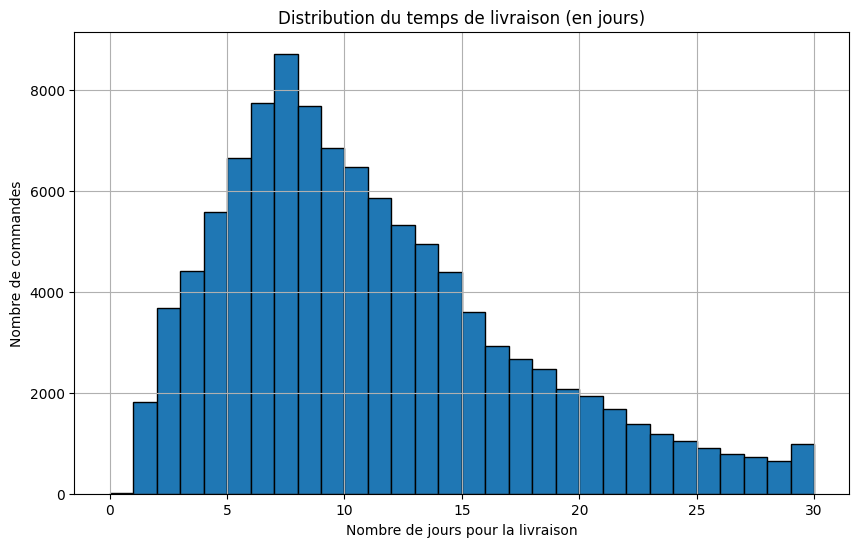

In [17]:
plt.figure(figsize=(10, 6))
plt.hist(data['delivery_time'], bins=range(0, data['delivery_time'].max() + 1), edgecolor='black')
plt.title('Distribution du temps de livraison (en jours)')
plt.xlabel('Nombre de jours pour la livraison')
plt.ylabel('Nombre de commandes')
plt.grid(True)
plt.show()

## Visualisation

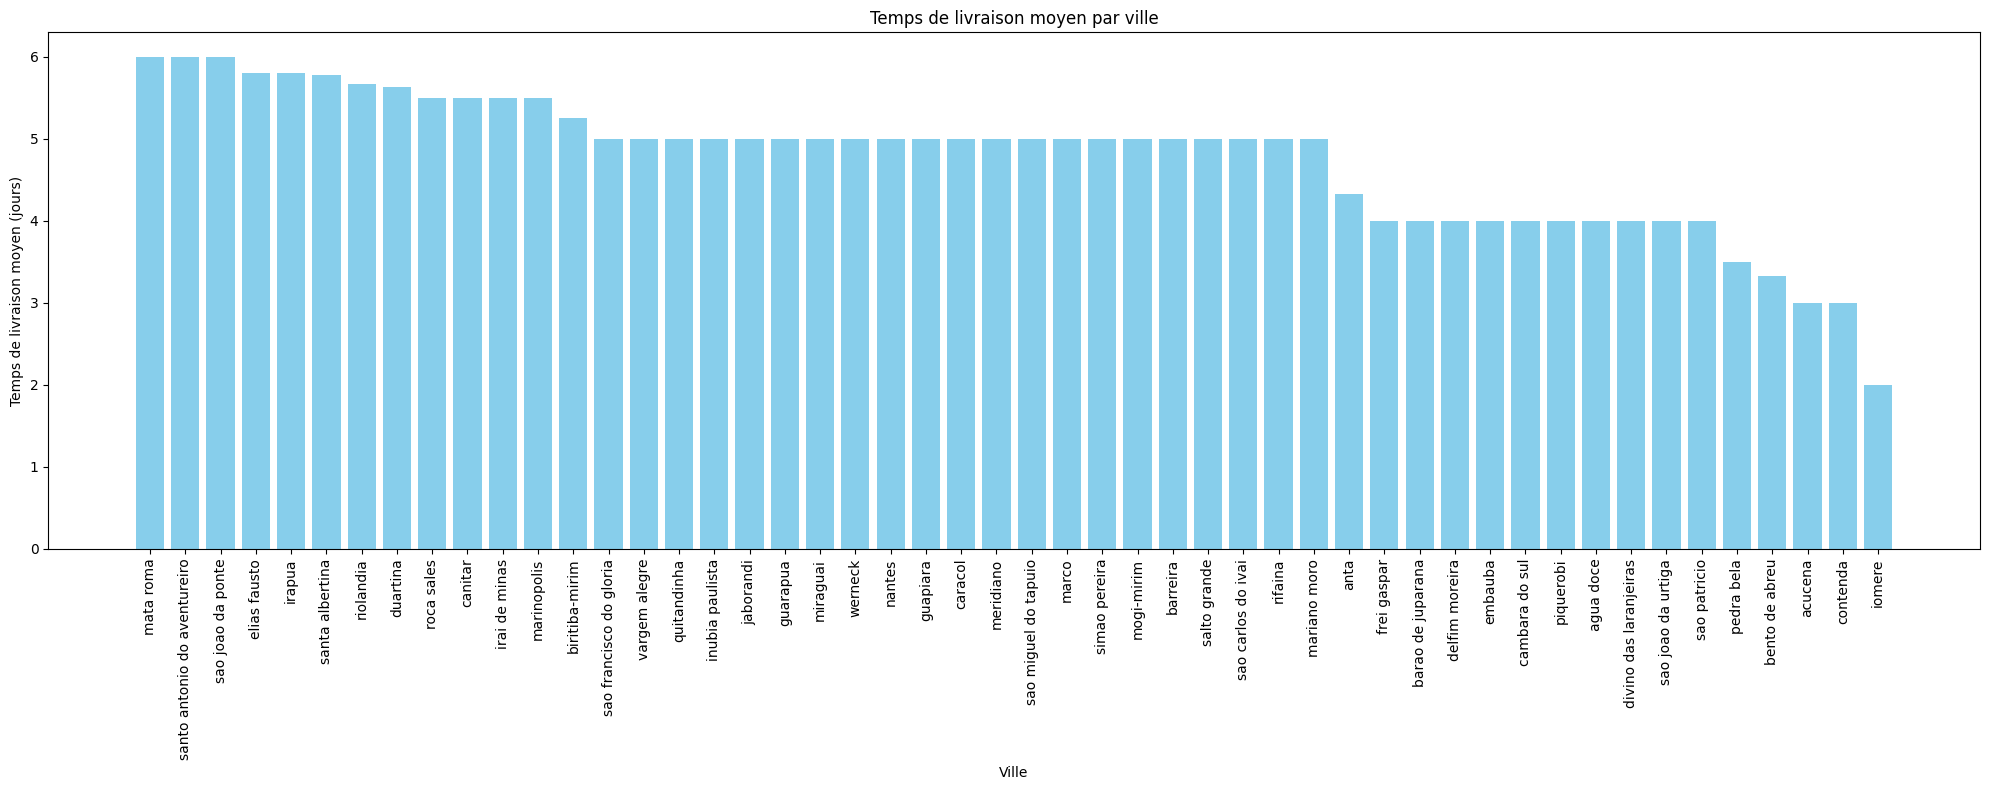

In [16]:
# Calculer la moyenne du temps de livraison pour chaque ville
temps_moyens_par_ville = data.groupby('customer_city')['delivery_time'].mean().reset_index()

# Trier les villes par la moyenne du temps de livraison
temps_moyens_par_ville = temps_moyens_par_ville.sort_values('delivery_time', ascending=False)

# les villes avec les plus rapides délais
ville = temps_moyens_par_ville.tail(50) 

# graphique à barre
plt.figure(figsize=(20, 8))
plt.bar(ville['customer_city'], ville['delivery_time'], color='skyblue')
plt.xlabel('Ville')
plt.ylabel('Temps de livraison moyen (jours)')
plt.title('Temps de livraison moyen par ville')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

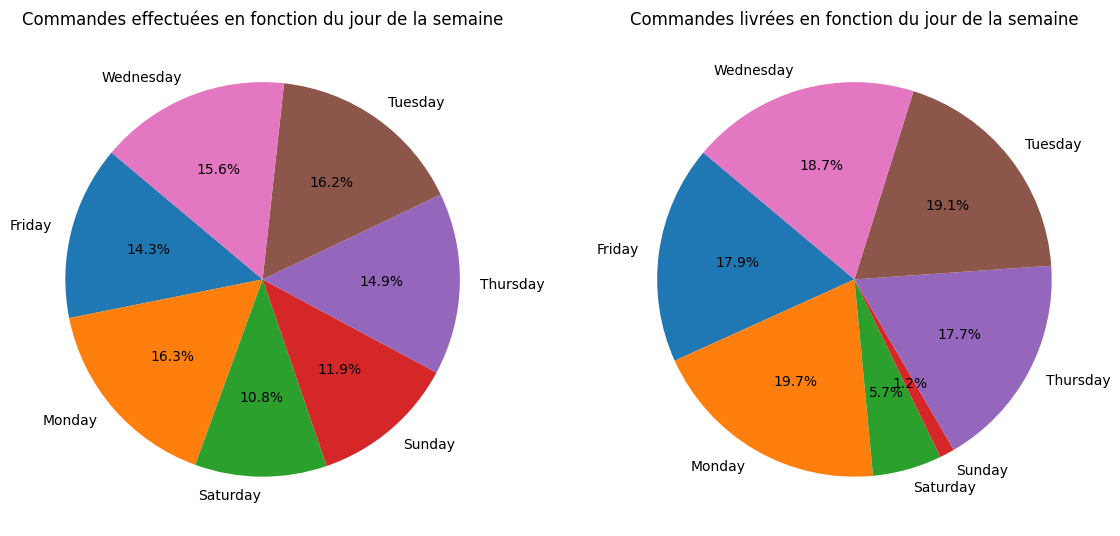

In [18]:
# Convertir les colonnes de timestamp en datetime
dt['order_purchase_timestamp'] = pd.to_datetime(dt['order_purchase_timestamp'])
dt['order_delivered_customer_date'] = pd.to_datetime(dt['order_delivered_customer_date'])

# Ajouter une colonne pour le jour de la semaine pour les achats et les livraisons
dt['purchase_day'] = dt['order_purchase_timestamp'].dt.day_name()
dt['delivery_day'] = dt['order_delivered_customer_date'].dt.day_name()

# Nombre total de commandes par jour de la semaine
orders_per_day = dt['purchase_day'].value_counts().sort_index()

# Nombre de commandes livrées par jour de la semaine
delivered_per_day = dt[dt['order_status'] == 'delivered']['delivery_day'].value_counts().sort_index()

# Calcul des pourcentages
orders_per_day_percent = (orders_per_day / orders_per_day.sum()) * 100
delivered_per_day_percent = (delivered_per_day / delivered_per_day.sum()) * 100

# Créer une figure avec deux sous-graphes
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Graphique pour les commandes effectuées
axes[0].pie(orders_per_day_percent, labels=orders_per_day_percent.index, autopct='%1.1f%%', startangle=140)
axes[0].set_title('Commandes effectuées en fonction du jour de la semaine')

# Graphique pour les commandes livrées
axes[1].pie(delivered_per_day_percent, labels=delivered_per_day_percent.index, autopct='%1.1f%%', startangle=140)
axes[1].set_title('Commandes livrées en fonction du jour de la semaine')

plt.show()

## III- Modélisation 


## Features et Target

In [19]:
# Les Feautures
X = ['distance_km','price', 'freight_value','customer_city_encoded','order_purchase_timestamp_days', 'order_approved_at_days','product_weight_g','product_length_cm', 'volume_cm3','order_delivered_carrier_date_days']

# Les target (temps de livraison en jours)
y = 'order_delivered_customer_date_days'

## Préparation pour la modélisation

In [23]:
# Imputation
imputer = SimpleImputer(strategy='mean')
features = data[X]
target = data[y]
X_imputed = pd.DataFrame(imputer.fit_transform(features), columns=features.columns, index= features.index)


# 20% données de tests
X_train, X_test, y_train, y_test = train_test_split(X_imputed,target,test_size=0.2, random_state=1)

## Matrice de corrélation 

<function matplotlib.pyplot.show(close=None, block=None)>

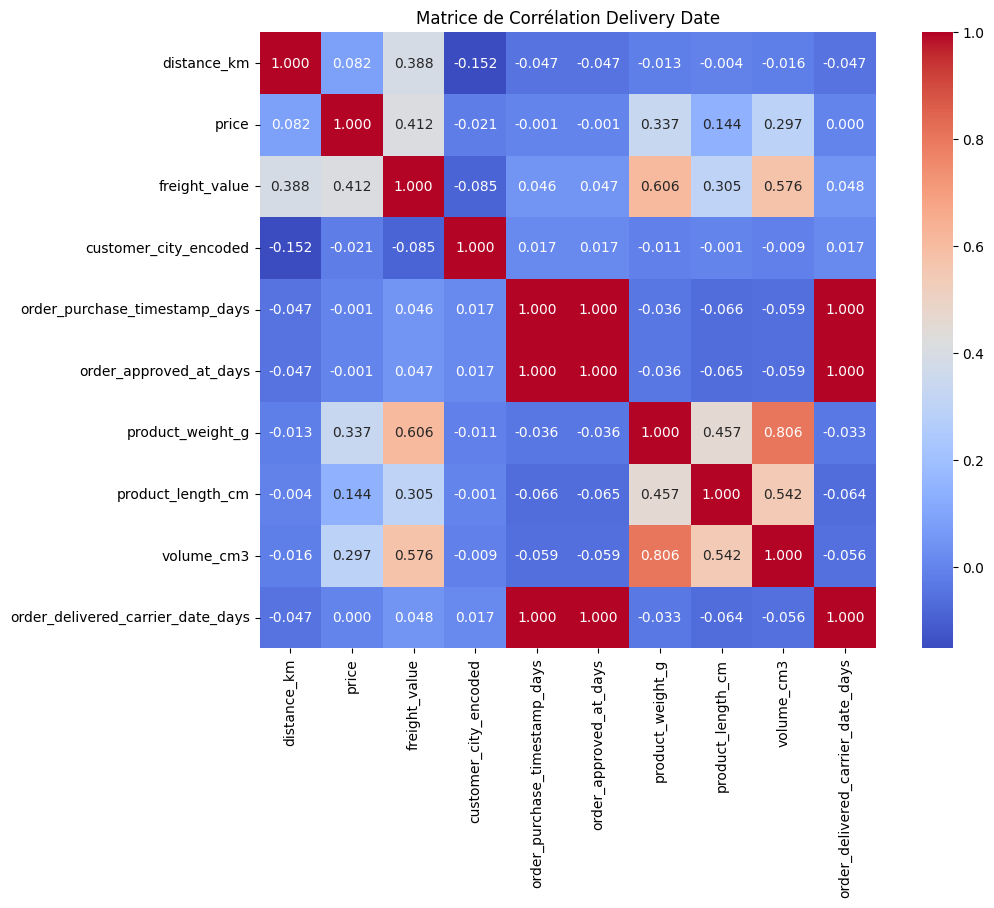

In [25]:
#Matrice de corrélation 
matrice = pd.DataFrame(X_imputed, columns=data[X].columns).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(matrice, annot=True, fmt=".3f", cmap='coolwarm', cbar=True, square=True)
plt.title('Matrice de Corrélation Delivery Date')
plt.show


## IV- Entraînement du Modèle

## 1- Régression Linéaire

## a- équation du modèle

## b- Fonction de coût

## 2- Random Forest Regressor

## Évaluation de Différents Modèles

In [26]:
# Les modèles
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'RandomForestRegressor' : RandomForestRegressor(n_estimators=100, random_state=1)
}

variance = data['delivery_time'].var()
ecart_type = data['delivery_time'].std()
print(f"Variance de 'delivery_time': {variance}")
print(f"Écart type de 'delivery_time': {ecart_type}")

# Entraîner et évaluer les modèles
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test) 
    rmse = mean_squared_error(y_test, y_pred, squared=False) # calcul du RMSE
    print(f'RMSE {name}: {rmse}')

Variance de 'delivery_time': 39.52772931368003
Écart type de 'delivery_time': 6.287108183710538
Training Linear Regression...
RMSE Linear Regression: 4.981443505739006
Training Ridge Regression...
RMSE Ridge Regression: 4.981443206295908
Training Lasso Regression...
RMSE Lasso Regression: 5.247752232529371
Training RandomForestRegressor...
RMSE RandomForestRegressor: 4.1824701242356594


## RMSE

## Precited Delivery Time 

In [27]:
#on ajoute les prédicitions au dataset
data.loc[X_test.index, 'predicted_delivery_time'] = y_pred

## Validation Croisée

In [36]:
# Validation croisée
for name, model in models.items():
    vc = cross_val_score(model, X_imputed, target, cv=5,scoring='neg_root_mean_squared_error')
    print(f'Cross validation for {name}: {-vc.mean()}')


Cross validation for Linear Regression: 4.880914859507612
Cross validation for Ridge Regression: 4.880914849121079
Cross validation for Lasso Regression: 5.215871280759965
Cross validation for RandomForestRegressor: 4.360999282559134


## Visualisation Dates Réelles vs Prédits

    delivery_time  predicted_delivery_time
1              13                      8.0
4               2                      3.0
7               9                     14.0
9              18                     13.0
11             12                     12.0


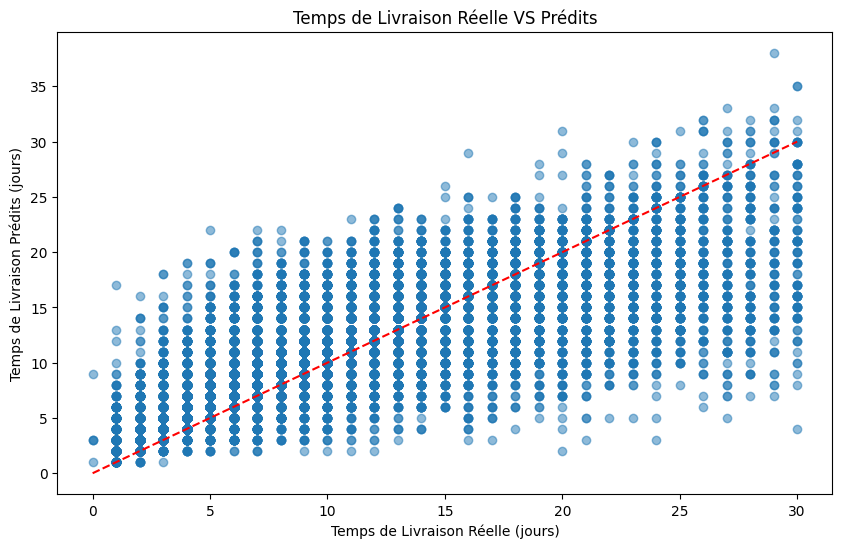

In [37]:
# ajuster les valeurs prédites pour qu'ils soient comparables avec les dates réelles 
data['predicted_delivery_time'] = data['predicted_delivery_time'] - data['order_purchase_timestamp_days']
data['predicted_delivery_time'] = round(data['predicted_delivery_time'])

# Trouver les entrées avec des valeurs négatives de temps de livraison prédit
anomalies = data[data['predicted_delivery_time'] < 0]

# Supprimer les anomalies 
if not anomalies.empty:
    data = data[data['predicted_delivery_time'] >= 0]


print(data[['delivery_time', 'predicted_delivery_time']].head())

plt.figure(figsize=(10,6))
plt.scatter(data['delivery_time'], data['predicted_delivery_time'], alpha=0.5)
plt.plot([data['delivery_time'].min(), data['delivery_time'].max()], [data['delivery_time'].min(), data['delivery_time'].max()], 'r--')
plt.xlabel('Temps de Livraison Réelle (jours)')
plt.ylabel('Temps de Livraison Prédits (jours)')
plt.title('Temps de Livraison Réelle VS Prédits')
plt.show()

## V- Analyse Experimentale

## évalutation de la preformance du modèle

## Pourcentage d'exactitude

In [38]:
margin = 3
accurate_predictions = np.abs(data['delivery_time'] - data['predicted_delivery_time']) <= margin
accuracy_percentage = np.mean(accurate_predictions) * 100
print(f'Pourcentage d\'exactitude avec une marge de {margin} jours: {accuracy_percentage:.2f}%')

Pourcentage d'exactitude avec une marge de 3 jours: 70.57%


## Amélioration Possibles

## 1- Enrichissement des données

## 2- Tester autres modèles

## 3- Distance entre client et vendeur

## VI- Conclusion